# Main

In [1]:
import numpy as np
import cv2
import scipy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

In [5]:
def render_images(images):
    for image_name, image in images:
        plt.figure(figsize=(7,7))
        plt.axis('off')
        plt.imshow(image, cmap='gray')
        plt.title(image_name)
        plt.show()
    pass

def create_Toeplitz(size, n_stripes=1, decrease_order=3):
    T = np.zeros(size)
    T[:n_stripes] = (n_stripes - np.arange(0,n_stripes))/(decrease_order*n_stripes)
    T = la.toeplitz(T)
    return T

def deblur(img, ker_h, ker_w, rank=1):
    U_h, S_h, V_h = la.svd(ker_h)
    U_w, S_w, V_w = la.svd(ker_w)
    S_h_invtr = np.hstack([1/S_h[:rank],np.zeros(len(ker_h)-rank)])
    S_w_invtr = np.hstack([1/S_w[:rank],np.zeros(len(ker_w)-rank)])
    ker_h_invtr = V_h.T @ np.diag(S_h_invtr) @ U_h.T
    ker_w_invtr = U_w @ np.diag(S_w_invtr) @ V_w
    return ker_h_invtr @ img @ ker_w_invtr

def plot_imgs(index, title='results'):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))
    fig.suptitle(title)

    ax1.imshow(images[index], cmap='gray')
    ax1.set_title('original')
    ax1.axis('off')

    ax2.imshow(blurs[index], cmap='gray')
    ax2.set_title('noisy_blur')
    ax2.axis('off')

    ax3.imshow(deblur_full[index], cmap='gray')
    ax3.set_title('full_rank')
    ax3.axis('off')

    ax4.imshow(deblur_trunc[index], cmap='gray')
    ax4.set_title(f'truncatrd_rank, ssim = {best_ssim[index]}')
    ax4.axis('off');


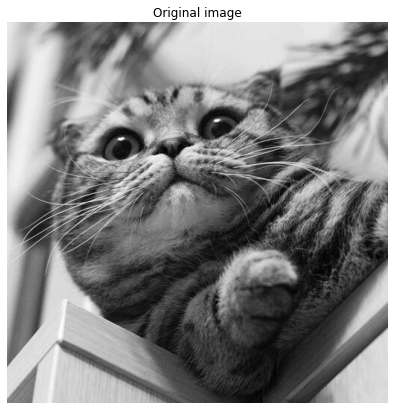

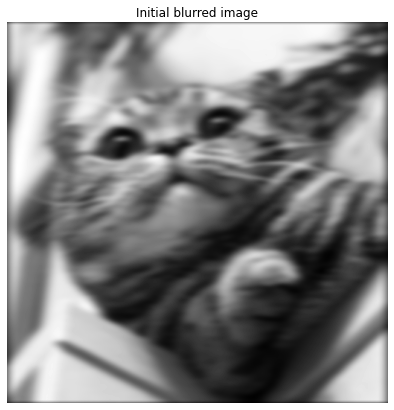

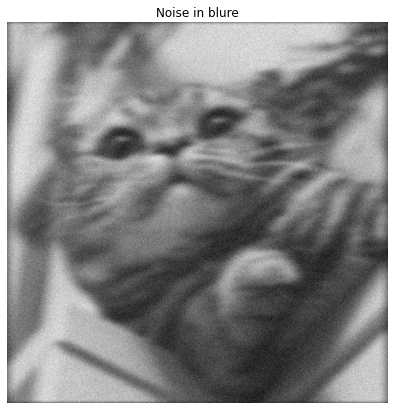

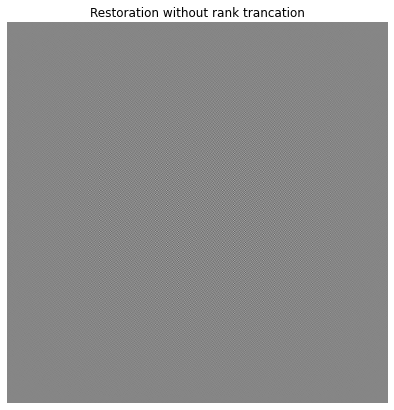

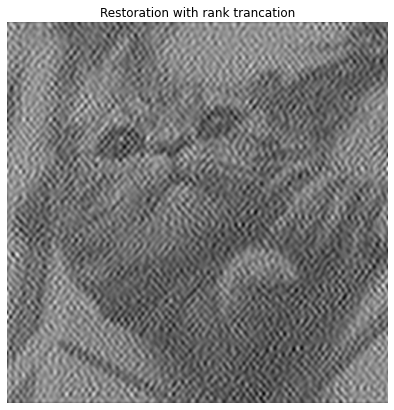

In [38]:
# read the image
cat = cv2.imread('img_test/cat.png')
cat = cv2.cvtColor(cat, cv2.COLOR_RGB2GRAY)
h = cat.shape[0]
w = cat.shape[1]
to_render = []
to_render.append(('Original image', cat))

A = create_Toeplitz(size=h, n_stripes=5)
B = create_Toeplitz(size=w, n_stripes=15)
pure_blur = A @ cat @ B
to_render.append(('Initial blurred image', pure_blur))

noisy_blur = A @ cat @B + 100*np.random.randn(h,w)
to_render.append(('Noise in blure', noisy_blur))

bad_deblur = deblur(noisy_blur, A, B, rank=min((h,w)))
to_render.append(('Restoration without rank trancation', bad_deblur))

good_deblur = deblur(noisy_blur, A, B, rank=100)
to_render.append(('Restoration with rank trancation', good_deblur))

render_images(to_render)

# Test rank of truncates SVD

## Image size 256

In [ ]:
imgs = ['img_test/shiba.png', 'img_test/goose.png', 'img_test/peppers.png']

ssim_list = []
best_ssim = []
best_ssim_idx = []

images = []
blurs = []
deblur_full = []
deblur_trunc = []

for img in imgs:
  im = cv2.imread(img)
  im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
  images.append(im)

  h = im.shape[0]
  w = im.shape[1]

  A = create_Toeplitz(size=h, n_stripes=5)
  B = create_Toeplitz(size=w, n_stripes=15)
  pure_blur = A @ im @ B
  noisy_blur = A @ im @B + 100*np.random.randn(h,w)
  blurs.append(noisy_blur)

  im_ori = im.astype(float)
  ssim_i = []
  deblur_run = []

  for i in tqdm(range(1, min(h, w)+1)):
    deblur_img = deblur(noisy_blur, A, B, rank=i)
    deblur_run.append(deblur_img)
    ssim_i.append(ssim(im_ori, deblur_img))

  ssim_list.append(ssim_i)
  idx = ssim_i.index(max(ssim_i))
  best_ssim_idx.append(idx)
  best_ssim.append(max(ssim_i))

  deblur_full.append(deblur_run[-1])
  deblur_trunc.append(deblur_run[idx])


100%|██████████| 256/256 [00:28<00:00,  8.93it/s]


shiba: best ssim = 0.2827895072322408 at truncated rank = 25
goose: best ssim = 0.307735842568979 at truncated rank = 27
peppers: best ssim = 0.32831531883154524 at truncated rank = 26


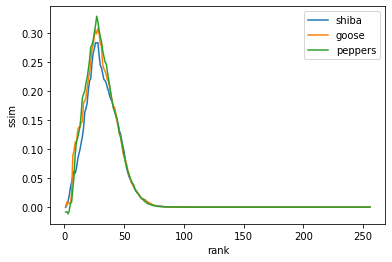

In [ ]:
rank_list = list(range(1, 256+1))

print(f'shiba: best ssim = {best_ssim[0]} at truncated rank = {best_ssim_idx[0]}')
print(f'goose: best ssim = {best_ssim[1]} at truncated rank = {best_ssim_idx[1]}')
print(f'peppers: best ssim = {best_ssim[2]} at truncated rank = {best_ssim_idx[2]}')

plt.plot(rank_list, ssim_list[0], label='shiba')
plt.plot(rank_list, ssim_list[1], label='goose')
plt.plot(rank_list, ssim_list[2], label='peppers')
plt.xlabel('rank')
plt.ylabel('ssim')
plt.legend();

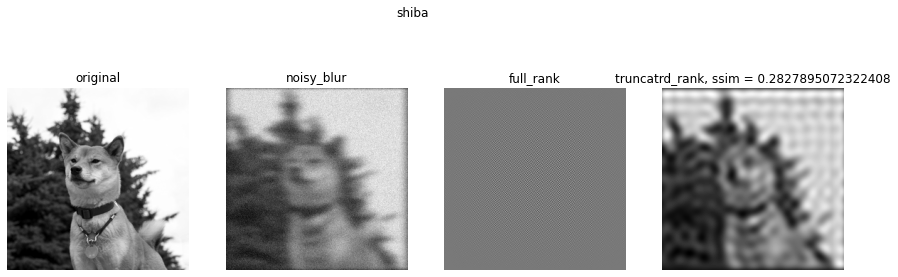

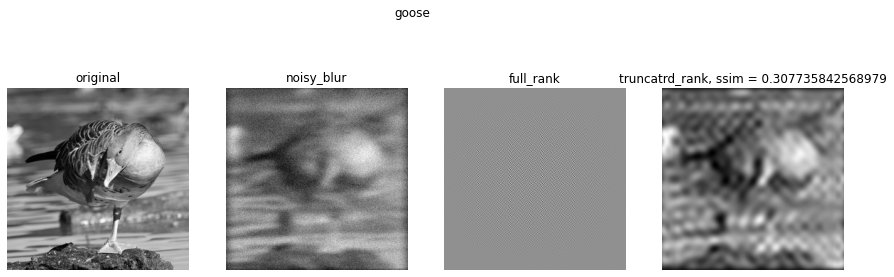

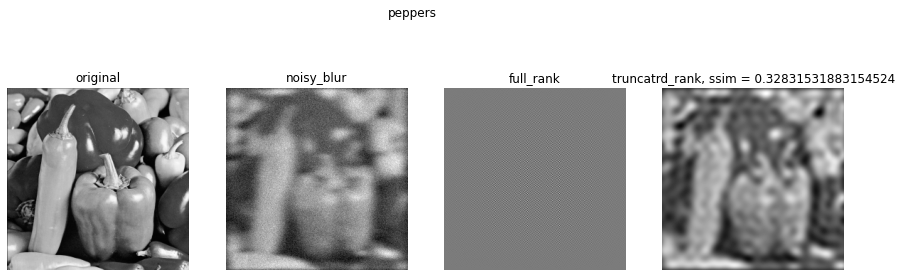

In [ ]:
plot_imgs(0, title='shiba')
plot_imgs(1, title='goose')
plot_imgs(2, title='peppers')

## Image size 512

In [ ]:
imgs = ['img_test/cat.png', 'img_test/baboon.png', 'img_test/lena.png']

ssim_list = []
best_ssim = []
best_ssim_idx = []

images = []
blurs = []
deblur_full = []
deblur_trunc = []

for img in imgs:
  im = cv2.imread(img)
  im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
  images.append(im)

  h = im.shape[0]
  w = im.shape[1]

  A = create_Toeplitz(size=h, n_stripes=5)
  B = create_Toeplitz(size=w, n_stripes=15)
  pure_blur = A @ im @ B
  noisy_blur = A @ im @B + 100*np.random.randn(h,w)
  blurs.append(noisy_blur)

  im_ori = im.astype(float)
  ssim_i = []
  deblur_run = []

  for i in tqdm(range(1, min(h, w)+1)):
    deblur_img = deblur(noisy_blur, A, B, rank=i)
    deblur_run.append(deblur_img)
    ssim_i.append(ssim(im_ori, deblur_img))

  ssim_list.append(ssim_i)
  idx = ssim_i.index(max(ssim_i))
  best_ssim_idx.append(idx)
  best_ssim.append(max(ssim_i))

  deblur_full.append(deblur_run[-1])
  deblur_trunc.append(deblur_run[idx])


100%|██████████| 512/512 [03:10<00:00,  2.68it/s]


cat: best ssim = 0.38041476769184923 at truncated rank = 50
baboon: best ssim = 0.1380380031258109 at truncated rank = 53
lena: best ssim = 0.24656765862833527 at truncated rank = 47


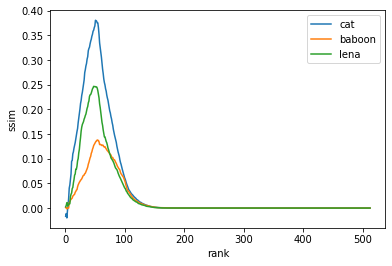

In [ ]:
rank_list = list(range(1, 512+1))

print(f'cat: best ssim = {best_ssim[0]} at truncated rank = {best_ssim_idx[0]}')
print(f'baboon: best ssim = {best_ssim[1]} at truncated rank = {best_ssim_idx[1]}')
print(f'lena: best ssim = {best_ssim[2]} at truncated rank = {best_ssim_idx[2]}')

plt.plot(rank_list, ssim_list[0], label='cat')
plt.plot(rank_list, ssim_list[1], label='baboon')
plt.plot(rank_list, ssim_list[2], label='lena')
plt.xlabel('rank')
plt.ylabel('ssim')
plt.legend();

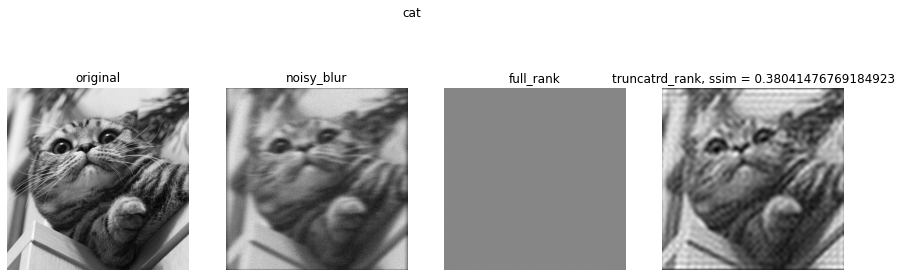

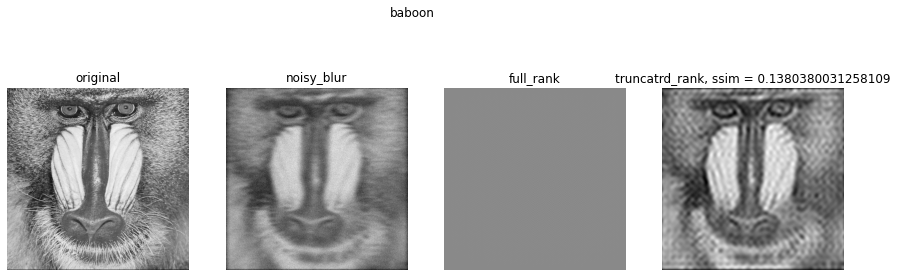

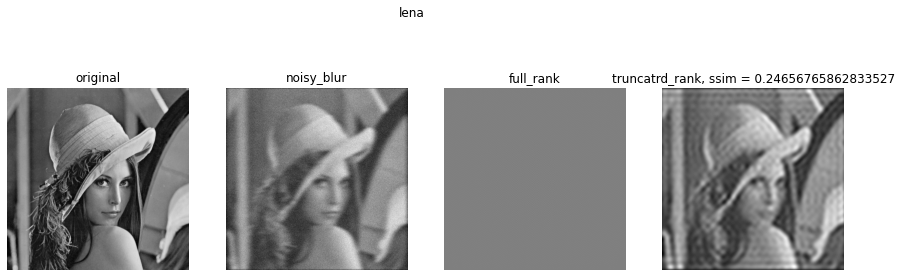

In [ ]:
plot_imgs(0, title='cat')
plot_imgs(1, title='baboon')
plot_imgs(2, title='lena')

# Level of noise and rank

In [ ]:
imgs = ['img_test/shiba.png', 'img_test/goose.png', 'img_test/peppers.png']

ssim_list = []
best_ssim = []
best_ssim_idx = []

images = []
blurs = []
deblur_full = []
deblur_trunc = []

for img in imgs:
  im = cv2.imread(img)
  im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
  images.append(im)

  h = im.shape[0]
  w = im.shape[1]

  A = create_Toeplitz(size=h, n_stripes=5)
  B = create_Toeplitz(size=w, n_stripes=15)
  pure_blur = A @ im @ B
  noisy_blur = A @ im @B + 10*np.random.randn(h,w)
  blurs.append(noisy_blur)

  im_ori = im.astype(float)
  ssim_i = []
  deblur_run = []

  for i in tqdm(range(1, min(h, w)+1)):
    deblur_img = deblur(noisy_blur, A, B, rank=i)
    deblur_run.append(deblur_img)
    ssim_i.append(ssim(im_ori, deblur_img))

  ssim_list.append(ssim_i)
  idx = ssim_i.index(max(ssim_i))
  best_ssim_idx.append(idx)
  best_ssim.append(max(ssim_i))

  deblur_full.append(deblur_run[-1])
  deblur_trunc.append(deblur_run[idx])


100%|██████████| 256/256 [00:22<00:00, 11.23it/s]


shiba: best ssim = 0.40678580898352196 at truncated rank = 48
goose: best ssim = 0.47452346745554047 at truncated rank = 48
peppers: best ssim = 0.41920300349410927 at truncated rank = 46


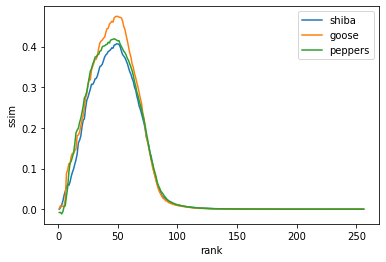

In [ ]:
rank_list = list(range(1, 256+1))

print(f'shiba: best ssim = {best_ssim[0]} at truncated rank = {best_ssim_idx[0]}')
print(f'goose: best ssim = {best_ssim[1]} at truncated rank = {best_ssim_idx[1]}')
print(f'peppers: best ssim = {best_ssim[2]} at truncated rank = {best_ssim_idx[2]}')

plt.plot(rank_list, ssim_list[0], label='shiba')
plt.plot(rank_list, ssim_list[1], label='goose')
plt.plot(rank_list, ssim_list[2], label='peppers')
plt.xlabel('rank')
plt.ylabel('ssim')
plt.legend();

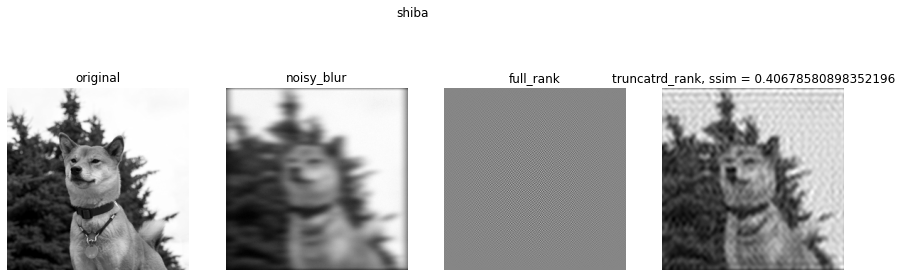

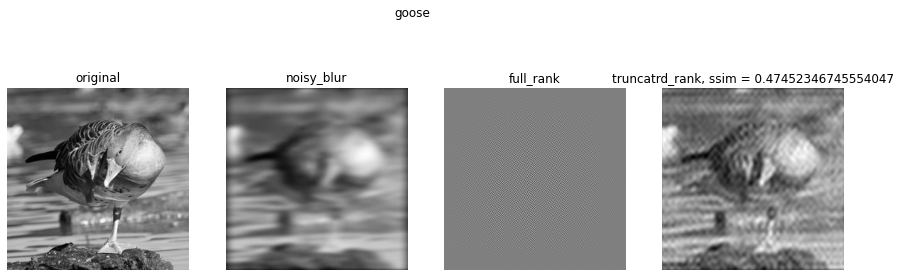

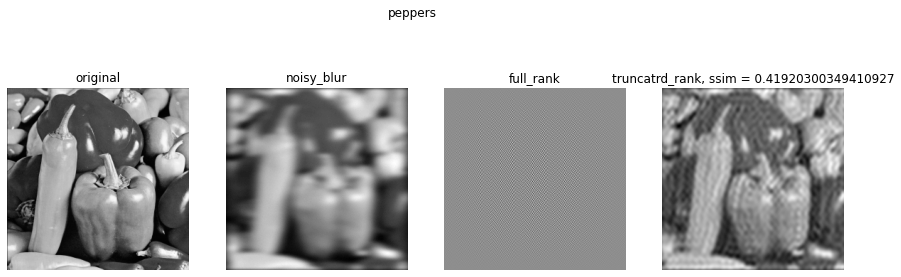

In [ ]:
plot_imgs(0, title='shiba')
plot_imgs(1, title='goose')
plot_imgs(2, title='peppers')

In [ ]:
imgs = ['img_test/cat.png', 'img_test/baboon.png', 'img_test/lena.png']

ssim_list = []
best_ssim = []
best_ssim_idx = []

images = []
blurs = []
deblur_full = []
deblur_trunc = []

for img in imgs:
  im = cv2.imread(img)
  im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
  images.append(im)

  h = im.shape[0]
  w = im.shape[1]

  A = create_Toeplitz(size=h, n_stripes=5)
  B = create_Toeplitz(size=w, n_stripes=15)
  pure_blur = A @ im @ B
  noisy_blur = A @ im @B + 10*np.random.randn(h,w)
  blurs.append(noisy_blur)

  im_ori = im.astype(float)
  ssim_i = []
  deblur_run = []

  for i in tqdm(range(1, min(h, w)+1)):
    deblur_img = deblur(noisy_blur, A, B, rank=i)
    deblur_run.append(deblur_img)
    ssim_i.append(ssim(im_ori, deblur_img))

  ssim_list.append(ssim_i)
  idx = ssim_i.index(max(ssim_i))
  best_ssim_idx.append(idx)
  best_ssim.append(max(ssim_i))

  deblur_full.append(deblur_run[-1])
  deblur_trunc.append(deblur_run[idx])


100%|██████████| 512/512 [03:16<00:00,  2.61it/s]


cat: best ssim = 0.4728389348169456 at truncated rank = 80
baboon: best ssim = 0.2681501152376638 at truncated rank = 102
lena: best ssim = 0.32043699771144774 at truncated rank = 88


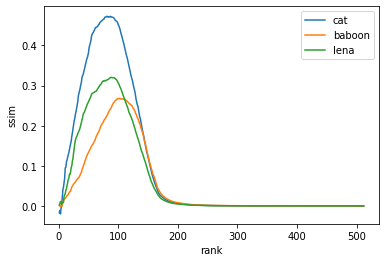

In [ ]:
rank_list = list(range(1, 512+1))

print(f'cat: best ssim = {best_ssim[0]} at truncated rank = {best_ssim_idx[0]}')
print(f'baboon: best ssim = {best_ssim[1]} at truncated rank = {best_ssim_idx[1]}')
print(f'lena: best ssim = {best_ssim[2]} at truncated rank = {best_ssim_idx[2]}')

plt.plot(rank_list, ssim_list[0], label='cat')
plt.plot(rank_list, ssim_list[1], label='baboon')
plt.plot(rank_list, ssim_list[2], label='lena')
plt.xlabel('rank')
plt.ylabel('ssim')
plt.legend();

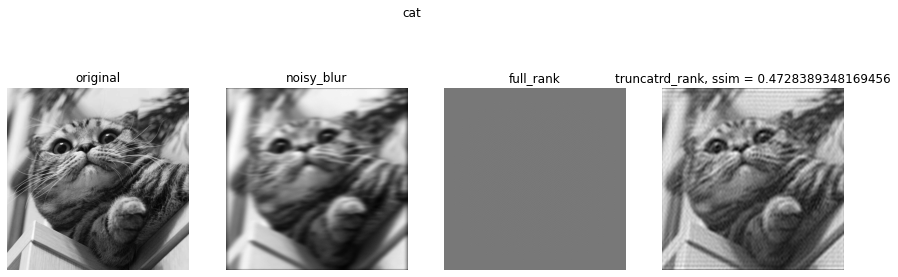

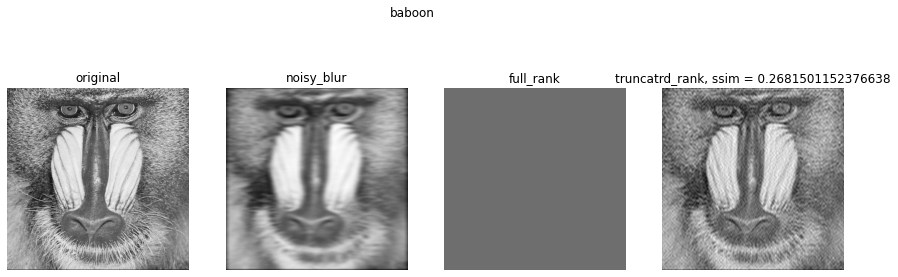

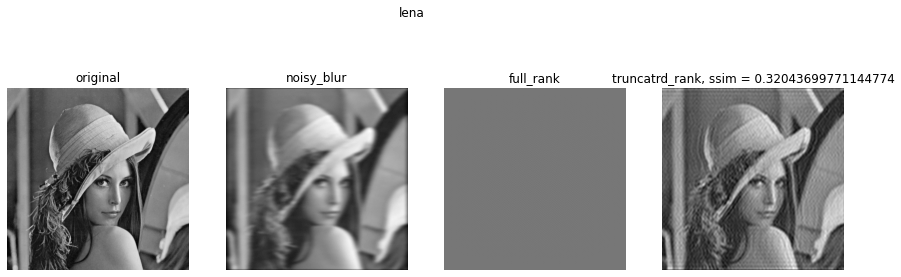

In [ ]:
plot_imgs(0, title='cat')
plot_imgs(1, title='baboon')
plot_imgs(2, title='lena')

In [10]:
def test(img, noise_lev, n_stripes_A, n_stripes_B):

  best_ssim = []
  best_ssim_idx = []

  img = cv2.imread(img)
  im = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  h = im.shape[0]
  w = im.shape[1]

  A = create_Toeplitz(size=h, n_stripes=n_stripes_A)
  B = create_Toeplitz(size=w, n_stripes=n_stripes_B)
  pure_blur = A @ im @ B
  noisy_blur = A @ im @B + noise_lev*np.random.randn(h,w)

  im_ori = im.astype(float)
  ssim_i = []

  for i in tqdm(range(1, min(h, w)+1)):
    deblur_img = deblur(noisy_blur, A, B, rank=i)
    ssim_i.append(ssim(im_ori, deblur_img))

  idx = ssim_i.index(max(ssim_i))
  best_ssim_idx.append(idx)
  best_ssim.append(max(ssim_i))

  return best_ssim, best_ssim_idx


In [11]:
imgs = ['img_test/shiba.png']

noise_level = list(range(0, 101, 10))

best_ssim_list = []
best_ssim_idx_list = []

for i in noise_level:
  best_ssim, best_ssim_idx = test(imgs[0], i, 5, 15)
  best_ssim_list.append(best_ssim)
  best_ssim_idx_list.append(best_ssim_idx)

100%|██████████| 256/256 [00:34<00:00,  7.40it/s]


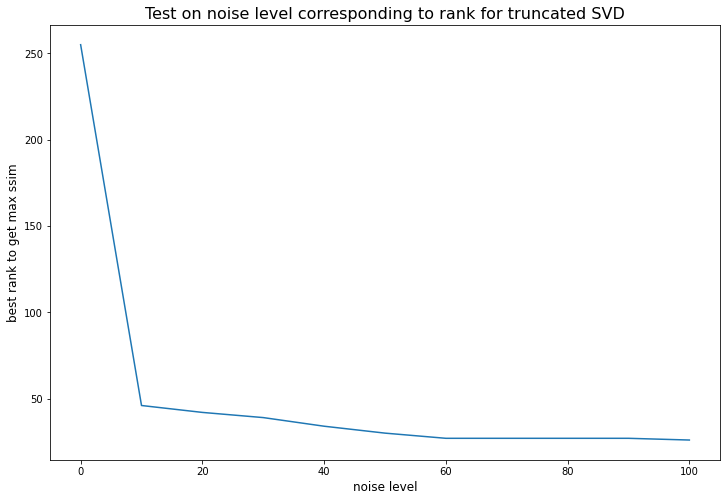

In [12]:
plt.figure(figsize=(12,8))
plt.title('Test on noise level corresponding to rank for truncated SVD', fontsize=16)
plt.plot(noise_level, best_ssim_idx_list)
plt.xlabel('noise level', fontsize=12)
plt.ylabel('best rank to get max ssim', fontsize=12);

# kernel blur

In [14]:
imgs = ['img_test/shiba.png']

stripes = list(range(5, 21, 5))

idx = []
best_ssim_list = []
best_ssim_idx_list = []

for i in stripes:
  for j in stripes:
    idx.append((i,j))
    best_ssim, best_ssim_idx = test(imgs[0], 100, i, j)
    best_ssim_list.append(best_ssim)
    best_ssim_idx_list.append(best_ssim_idx)

100%|██████████| 256/256 [00:32<00:00,  7.96it/s]


In [15]:
x = []
y = []
z = []

for i in range(len(idx)):
  x.append(idx[i][0])
  y.append(idx[i][1])
  z.append(best_ssim_idx_list[i])

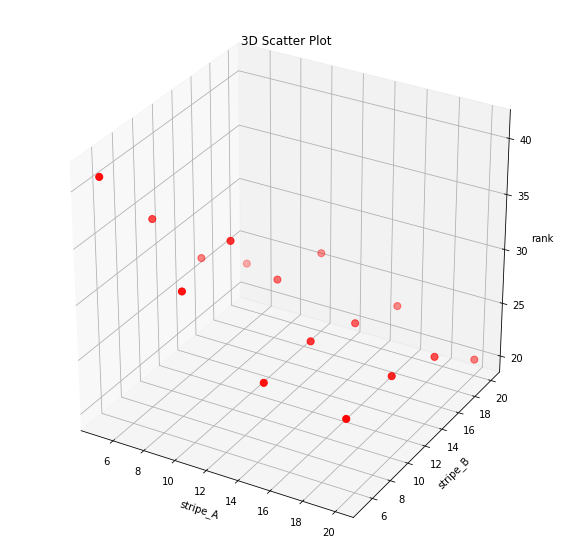

In [19]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()

ax.scatter(x, y, z, c = 'r', s = 50)
ax.set_title('3D Scatter Plot')

# Set axes label
ax.set_xlabel('stripe_A', labelpad=5)
ax.set_ylabel('stripe_B', labelpad=5)
ax.set_zlabel('rank', labelpad=5)

plt.show()

In [20]:
data = []
for i in range(0,16,4):
  data.append(z[i])
  i += 3

In [21]:
data

[[41], [33], [27], [26]]

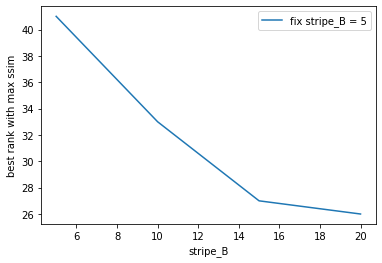

In [22]:
x_range = list(range(5, 21, 5))
plt.plot(x_range, data, label='fix stripe_B = 5')
plt.xlabel('stripe_B')
plt.ylabel('best rank with max ssim')
plt.legend();

fix stripe_B = 5

In [23]:
imgs = ['img_test/shiba.png']

stripes = list(range(10, 101, 10))

best_ssim_list = []
best_ssim_idx_list = []

for i in stripes:
    best_ssim, best_ssim_idx = test(imgs[0], 100, i, 5)
    best_ssim_list.append(best_ssim)
    best_ssim_idx_list.append(best_ssim_idx)

100%|██████████| 256/256 [00:31<00:00,  8.03it/s]


fix stripe_B = 10

In [24]:
best_ssim_list_1 = []
best_ssim_idx_list_1 = []

for i in stripes:
    best_ssim, best_ssim_idx = test(imgs[0], 100, i, 10)
    best_ssim_list_1.append(best_ssim)
    best_ssim_idx_list_1.append(best_ssim_idx)

100%|██████████| 256/256 [00:34<00:00,  7.48it/s]


fix stripe_B = 20

In [25]:
best_ssim_list_2 = []
best_ssim_idx_list_2 = []

for i in stripes:
    best_ssim, best_ssim_idx = test(imgs[0], 100, i, 20)
    best_ssim_list_2.append(best_ssim)
    best_ssim_idx_list_2.append(best_ssim_idx)

100%|██████████| 256/256 [00:31<00:00,  8.01it/s]


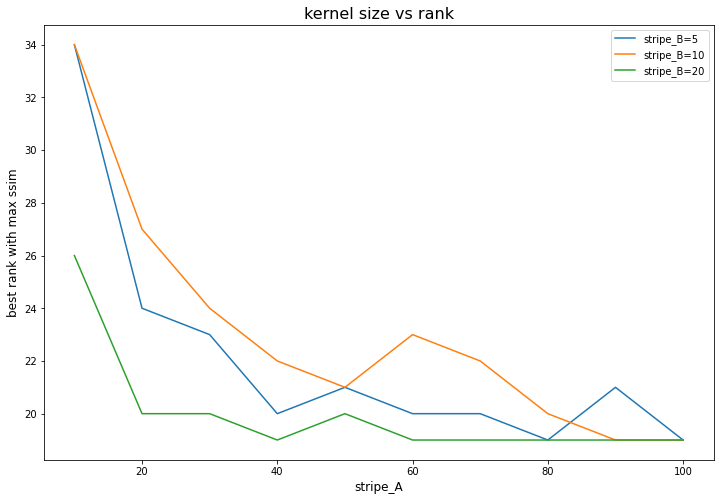

In [26]:
plt.figure(figsize = (12,8))
plt.plot(stripes, best_ssim_idx_list, label='stripe_B=5')
plt.plot(stripes, best_ssim_idx_list_1, label='stripe_B=10')
plt.plot(stripes, best_ssim_idx_list_2, label='stripe_B=20')
plt.xlabel('stripe_A', fontsize=12)
plt.ylabel('best rank with max ssim', fontsize=12)
plt.title('kernel size vs rank', fontsize=16)
plt.legend();

In [ ]:
imgs = ['img_test/shiba.png']

best_ssim_list_3 = []
best_ssim_idx_list_3 = []

for i in range(1,101):
    best_ssim, best_ssim_idx = test(imgs[0], 100, i, 10)
    best_ssim_list_3.append(best_ssim)
    best_ssim_idx_list_3.append(best_ssim_idx)

In [36]:
len(best_ssim_idx_list_3)

100

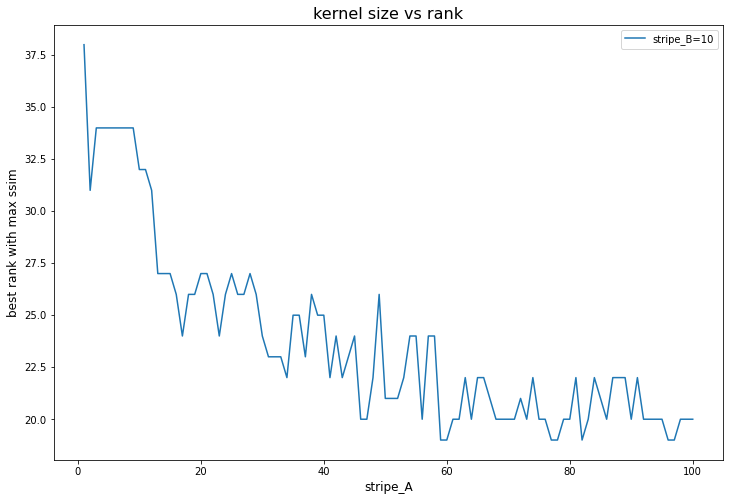

In [37]:
plt.figure(figsize = (12,8))
plt.plot(list(range(1,101)), best_ssim_idx_list_3, label='stripe_B=10')
plt.xlabel('stripe_A', fontsize=12)
plt.ylabel('best rank with max ssim', fontsize=12)
plt.title('kernel size vs rank', fontsize=16)
plt.legend();